In [1]:
from NSynthDataSet_RawAudio import NSynthDataSet_RawAudio
from transformers import GTransformer

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import RandomSampler

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from librosa.display import specshow

import random, sys, math, gzip, os
from tqdm import tqdm
from IPython.display import Audio 
import IPython
import soundfile 
import copy
import datetime


%load_ext autoreload
%autoreload 2

In [36]:
### Constants 

sample_rate = 16000

batch_size = 16
lr = 0.001
lr_warmup = 5000
epochs = 100

sample_length = 512 # For context
embedding_size = 128 
num_heads = 8 # Number of chunks for 'parallel/ensemble' computation
depth = 12 # Number of transformer layers
num_tokens = 256 #Size of the dictionary

sample_index = 11
use_temperature = True
temperature = 0.5

In [38]:
model = GTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=sample_length, num_tokens=num_tokens, attention_type=None)
model = model.cuda()

opt = torch.optim.Adam(lr=lr, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (lr_warmup / batch_size), 1.0))
loss = torch.nn.NLLLoss(reduction='mean')

In [39]:
print(model)
# model.token_embedding.register_forward_hook(lambda m, input, output: print(output))

GTransformer(
  (token_embedding): Linear(in_features=1, out_features=128, bias=True)
  (token_embedding_batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (token_embedding_activation): ReLU()
  (pos_embedding): Linear(in_features=512, out_features=128, bias=True)
  (pos_embedding_batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (pos_embedding_activation): ReLU()
  (tblocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=128, out_features=128, bias=False)
        (toqueries): Linear(in_features=128, out_features=128, bias=False)
        (tovalues): Linear(in_features=128, out_features=128, bias=False)
        (unifyheads): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Se

In [24]:
base_data_dir = '/home/purnima/appdir/Github/DATA/NSynth/'
labels_dir = '/home/purnima/appdir/Github/DATA/NSynth'

validate_data_dir = os.path.join(base_data_dir,'nsynth-validate','audio')
labels_validate_dir = os.path.join(labels_dir,'nsynth-validate', 'examples.json')

# validate_ds = NSynthDataSet_RawAudio(meta_data_file=labels_validate_dir, audio_dir=validate_data_dir, sr=sample_rate)
# validate_loader = torch.utils.data.DataLoader(validate_ds, batch_size=batch_size, shuffle=False)

## Sampling
Sampling is done as follows -  
1. Select an input from the dataloader (update sample_index to any value from 0 to 15). Shape will be `1 X sample_length` or `1 X 512`
2. Generate the output from the model. Shape will be `1 X 512 X 256`
3. Retrieve the last sample from the 512 sample_length dimension `sample_data = sample_data[0, -1, :]` (argmax or temperature sampling (-- I need to understand this more--)  
4. Append this sample to the input (from step 1). Both input and this new sample are between 0 - 255. Use this as the new input and repeat from Step 1 for as long as you want (here we are iterating through the steps 256 times to generate 256 new samples).
5. Convert this 512 + 256 new samples to waveform using mu_expand from librosa.

In [6]:
def load_model(model, opt, model_location):
    checkpoint = torch.load(model_location)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    epoch = checkpoint['epoch']
    return model, opt, loss, epoch

def mulawDecodeTarget(output):
    output = output - 127
    waveform = librosa.mu_expand(output, quantize=True)
    return waveform

def mulawDecode(output):
    output = (output * 2) - 1
    waveform = librosa.mu_expand(output, quantize=False)
    return waveform

In [7]:
def sample_model(seed):
    start_time = datetime.datetime.now().replace(microsecond=0)
    orig_waveform = mulawDecode(seed)
    final_sample_data = torch.from_numpy(copy.copy(seed)).view(1, -1).cuda()
    input_data = torch.from_numpy(copy.copy(seed)).cuda()
    
    # 1. Sample from model
    with torch.no_grad():
        for ind in range(int(sample_length) ):
#         for ind in range(20):
        
            input_data = input_data.view(1, -1, 1).float() #Convert to batch_size X seq_len X 1
            
            sample_data = model(input_data) #Output is batch_size X seq_length X one_hot len (256) i.e. 1 X 512 X 256. 
            
            if use_temperature:
                temperature = 0.2
                p = F.softmax(sample_data / temperature, dim=0)
                cd = dist.Categorical(p)
                sample_data = cd.sample()
                sample_data = sample_data[:,-1:]
            else:
                sample_data = sample_data[0, -1, :].argmax() #Get the last sample probabilities and argmax.
            
            
            sample_data = mulawDecodeTarget(sample_data.view(1,-1).cpu().numpy())
            sample_data = (librosa.mu_compress(sample_data, quantize=False) + 1)/2 #Just like what we do in NSynthDataSet_RawAudio.py
            sample_data = torch.from_numpy(sample_data).view(1,-1).cuda()
            
            final_sample_data = torch.cat((final_sample_data, sample_data), dim=1)
            input_data = final_sample_data[:,final_sample_data.shape[1]-sample_length:].view(1,-1)
    
    final_sample_data = final_sample_data.view(-1).cpu().numpy()
    waveform = mulawDecode(final_sample_data)
    
    # 2. Audio
    IPython.display.display(IPython.display.Audio(orig_waveform, rate=sample_rate))
    IPython.display.display(IPython.display.Audio(waveform, rate=sample_rate))
    
    # 3. Plot waveforms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    axes[0].plot(orig_waveform)
    axes[0].set_title('Original Seed')

    axes[1].plot(waveform)
    axes[1].set_title('New Sample')
    plt.show()
    
    # 4. Plot spectrograms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    
    D = librosa.stft(orig_waveform, n_fft=512)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[0])
    axes[0].set(title='Orig seed')
    fig.colorbar(img, ax=axes[0], format="%+2.f dB")
    
    D = librosa.stft(waveform, n_fft=512)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[1])
    axes[1].set(title='New Sample')
    fig.colorbar(img, ax=axes[1], format="%+2.f dB")
    plt.show()
    print('Time taken for sampling/plotting = ', datetime.datetime.now().replace(microsecond=0) - start_time)
    return waveform, orig_waveform

In [8]:
def get_data(idx, start_location):
    start_location = int(start_location * 16000)
    audio_file_name = os.path.join(validate_data_dir, idx+'.wav')
    audio_data, _ = librosa.load(audio_file_name, sr=sample_rate)
    input_data = audio_data[start_location:start_location + sample_length]

    fig, axes = plt.subplots(ncols=2, figsize=(8,4))
    axes[0].plot(audio_data)
    axes[0].set(title='Sample Length = 64000/4 secs')
    axes[1].plot(input_data)
    axes[1].set(title='Sample Length = 512/32 ms')
    
    input_data = (librosa.mu_compress(input_data, quantize=False) + 1)/2
    
    target = audio_data[start_location + 1:start_location + 1 + sample_length]
    target = librosa.mu_compress(target, quantize=True) + 127
    target = target.astype(np.long)
    
    return input_data, target

In [50]:
model, opt, loss, epoch = load_model(model, opt, 'checkpoint-secondsuccess-with-batchnorm/attention-36.pt')
print('Model Loaded')

Model Loaded


In [43]:
use_temperature = False

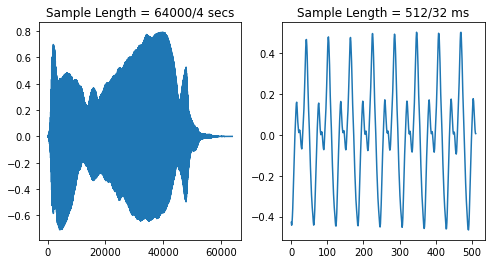

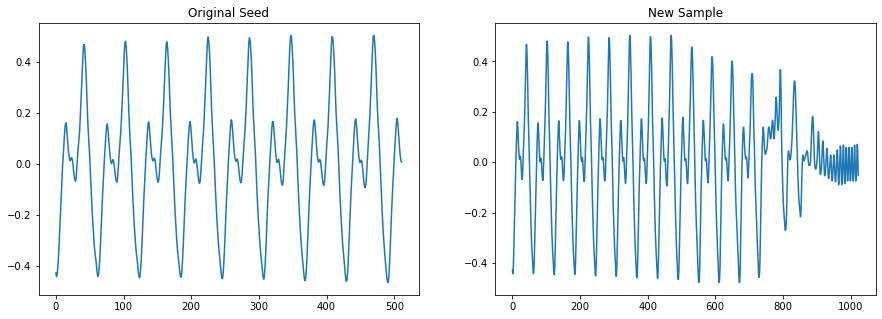

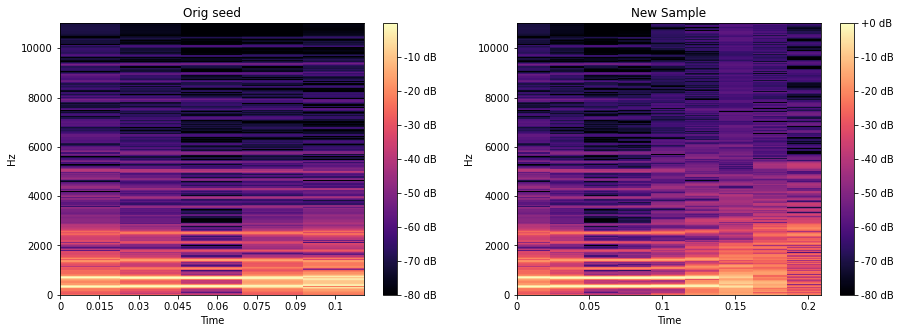

Time taken for sampling/plotting =  0:00:15


In [24]:
input_data, _ = get_data('reed_acoustic_037-060-075', 1.5)
new_sample, orig_seed = sample_model(input_data)

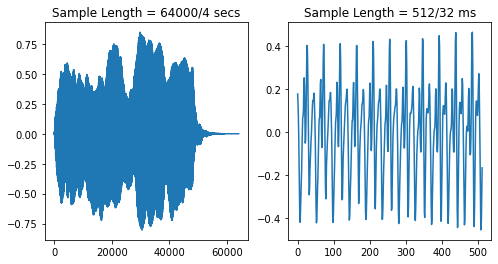

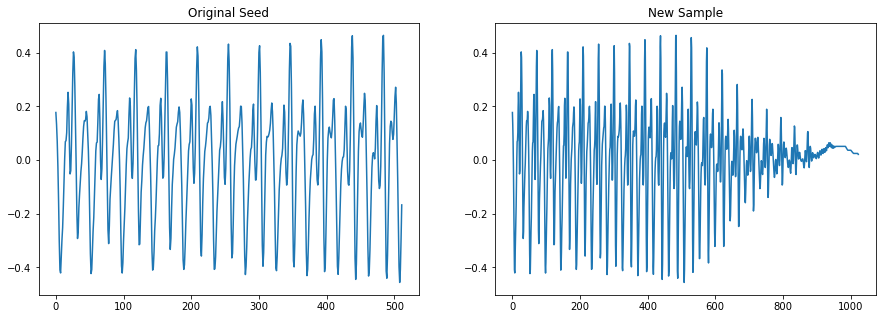

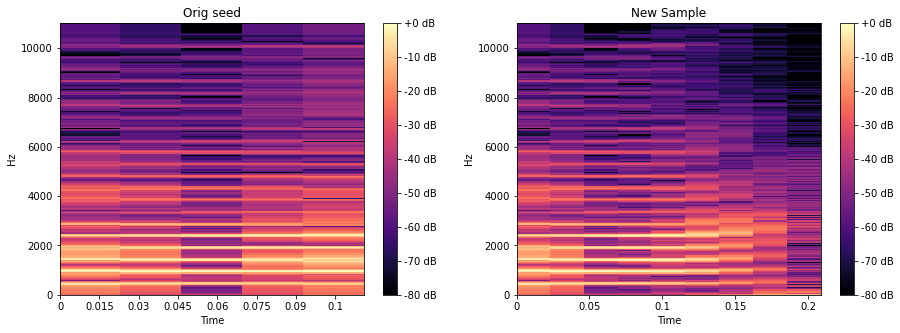

Time taken for sampling/plotting =  0:00:07


In [51]:
input_data, _ = get_data('reed_acoustic_041-065-127', 0.5)
new_sample, orig_seed = sample_model(input_data)

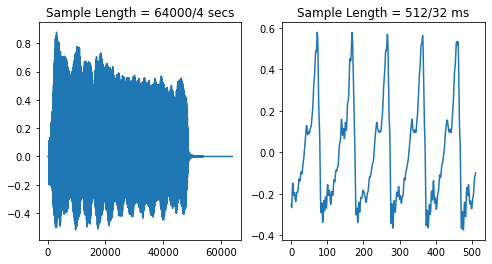

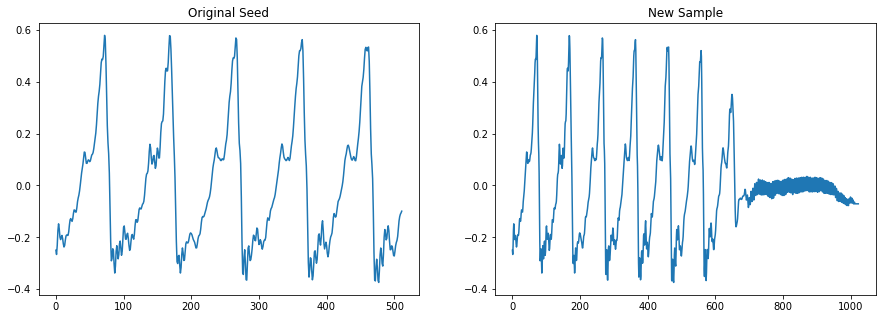

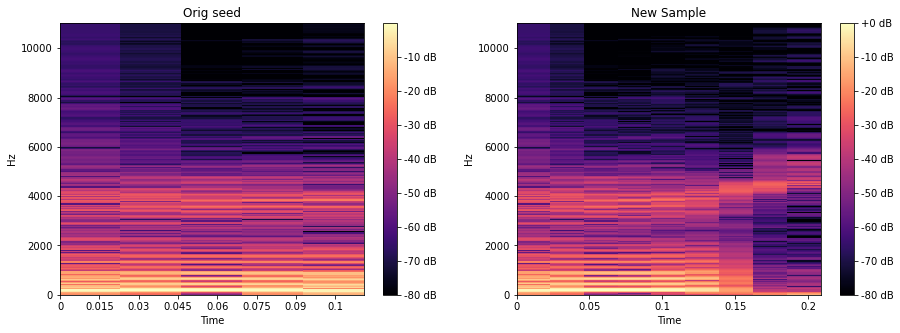

Time taken for sampling/plotting =  0:00:07


In [52]:
input_data, _ = get_data('reed_acoustic_051-052-025', 1.5)
new_sample, orig_seed = sample_model(input_data)